In [1]:
# Import packages
import pandas as pd
import numpy as np
from math import floor, ceil
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix , classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve, log_loss, auc)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from statsmodels.stats.weightstats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting random seed to ensure consistent results
rnd_num = 42
random.seed(rnd_num)
np.random.seed(rnd_num)

### Defining Functions

In [3]:
# function to print confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,4), fontsize=10):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="Greens", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=fontsize)
    plt.ylabel('True label\n')
    plt.xlabel('\nPredicted label')
    return fig

# calculate Number Needed to Treat
def calculate_nnt(y_nonreperfusion, y_reperfusion):
    ARR = abs(y_nonreperfusion.mean() - y_reperfusion.mean())
    
    NNT = ceil(1/ARR)
    if y_nonreperfusion.mean() > y_reperfusion.mean(): # number needed to treat (positive output)
        return NNT
    elif y_nonreperfusion.mean() < y_reperfusion.mean(): # number needed to harm (negative output)
        return -1*NNT
    elif y_nonreperfusion.mean() == y_reperfusion.mean(): # no effect
        return 0


# defining a function to calculate and plot AUROC and AUPRC and their 95% CI
def calculate_bootstrap_roc_pr(y_true, y_scores, n_bootstraps=1000):
    np.random.seed(rnd_num)
    n_size = len(y_true)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    bs_tpr = [] # bootstrapped true positive rate
    bs_precision = [] # bootstrapped precision
    bs_auroc = [] # bootstraped AUROC
    bs_auprc = [] # bootstrapped AUPRC

    base_fpr = np.linspace(0, 1, 101) # false positive rate
    base_recall = np.linspace(0, 1, 101) # recall

    for _ in range(n_bootstraps):
        indices = np.random.randint(0, n_size, n_size)
        y_true_resampled = y_true[indices]
        y_scores_resampled = y_scores[indices]

        if len(np.unique(y_true_resampled)) < 2:
            continue

        fpr, tpr, _ = roc_curve(y_true_resampled, y_scores_resampled)
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        bs_tpr.append(tpr_interp)
        bs_auroc.append(auc(fpr, tpr))

        precision, recall, _ = precision_recall_curve(y_true_resampled, y_scores_resampled)
        precision_interp = np.interp(base_recall, recall[::-1], precision[::-1])
        bs_precision.append(precision_interp)
        bs_auprc.append(auc(recall, precision))

    results = {
        'base_fpr': base_fpr,
        'mean_tpr': np.mean(bs_tpr, axis=0),
        'tpr_ci_lower': np.percentile(bs_tpr, 2.5, axis=0),
        'tpr_ci_upper': np.percentile(bs_tpr, 97.5, axis=0),
        'base_recall': base_recall,
        'mean_precision': np.mean(bs_precision, axis=0),
        'precision_ci_lower': np.percentile(bs_precision, 2.5, axis=0),
        'precision_ci_upper': np.percentile(bs_precision, 97.5, axis=0),
        'auroc': (np.mean(bs_auroc), np.percentile(bs_auroc, 2.5), np.percentile(bs_auroc, 97.5)),
        'auprc': (np.mean(bs_auprc), np.percentile(bs_auprc, 2.5), np.percentile(bs_auprc, 97.5))
    }
    return results

In [4]:
# setting font for the figures
plt.rcParams['font.family'] = 'Times New Roman'

# Data Preprocessing

In [5]:
# reading the dataset file
FILE = r"./GSR_imputed_KNN_RF.xlsx"
sheet_name = r"Sheet1"

df = pd.read_excel(io=FILE, sheet_name=sheet_name)

# defining pre-treatment features 
pre_treat_features = ['Age' , 'Sex' , 'Antithrombotic medication' , 'pre-mRS', 'NIHSS at admission',
                      'Hypertension' , 'Diabetes mellitus' , 'Dyslipidemia' , 'Atrial fibrillation' , 'ASPECTS',
                       'IVT', 'TICI before angio'
                      , 'Ant/post occlusion',
                      'BA occlusion', 'VA occlusion', 'PCA occlusion',
                     'ACA occlusion', 'CA intra T' , 'CA intra no-T' ,
                     'CA extra' , 'proximal M1 occlusion' ,
                     'MCA m1 dist occlusion' , 'MCA-M2 occlusion'
                      ]

In [6]:
# number of pre-reperfusion features
len(pre_treat_features)

23

In [7]:
# defining binary mRS and adding ID to each patient
df['D90_mrs_binary'] = df['D90_mrs'].replace([0, 1, 2], 0).replace([3,4,5,6], 1)
df = df[['Patient_ID'] + pre_treat_features + ['Final TICI'] + ['D90_mrs_binary']]

In [8]:
# deviding data into two groups: nonreperfusion and reperfusion based on their TICI score:
# 0, 1 and 2 are labels for TICI scores 0 , 1 and 2a
# 3 and 4 are labels for TICI score 2b and 3
df_nonreperfusion = df.query("`Final TICI` <= 2")[pre_treat_features]
df_nonreperfusion['D90_mrs_binary'] = df.query("`Final TICI` <= 2")['D90_mrs_binary']

df_reperfusion = df.query("`Final TICI` >= 3")[pre_treat_features]
df_reperfusion['D90_mrs_binary'] = df.query("`Final TICI` >= 3")['D90_mrs_binary']

In [9]:
# shape of each group: (number of patients, number of variables including pre-treat features and outcome)
print(f'nonreperfusion group shape: {df_nonreperfusion.shape}')
print(f'reperfusion group shape: {df_reperfusion.shape}')

Control group shape: (1718, 24)
Treatment group shape: (10339, 24)


In [10]:
# percentage of patients with bad outcome in each group
print(f'Ratio of bad outcome in nonreperfusion group: {df_nonreperfusion.D90_mrs_binary.mean()*100:.2f}')
print(f'Ratio of bad outcome in reperfusion group: {df_reperfusion.D90_mrs_binary.mean()*100:.2f}')

Ratio of bad outcome in control group: 86.55
Ratio of bad outcome in treatment group: 62.62


In [11]:
# number of patients with good outcome (0) and bad outcome (1) in nonreperfusion group
df_nonreperfusion.D90_mrs_binary.value_counts()

D90_mrs_binary
1    1487
0     231
Name: count, dtype: int64

In [12]:
# number of patients with good outcome (0) and bad outcome (1) in reperfusion group
df_reperfusion.D90_mrs_binary.value_counts()

D90_mrs_binary
1    6474
0    3865
Name: count, dtype: int64

In [13]:
# Number needed to treat
calculate_nnt(df_nonreperfusion.D90_mrs_binary, df_reperfusion.D90_mrs_binary)

5

## Train/Test split

In [14]:
# split data to train and test the model
X_train_nonreperfusion, X_test_nonreperfusion, y_train_nonreperfusion, y_test_nonreperfusion = train_test_split(
    df_nonreperfusion[pre_treat_features], df_nonreperfusion['D90_mrs_binary'], test_size=0.2, random_state=rnd_num)

X_train_reperfusion, X_test_reperfusion, y_train_reperfusion, y_test_reperfusion = train_test_split(
    df_reperfusion[pre_treat_features], df_reperfusion['D90_mrs_binary'], test_size=0.2, random_state=rnd_num)

# Random Forest

## Training RF<sub>nr</sub>

In [15]:
# training random forst RFnr on data from nonreperfusion group. optimizing using grid search with 5-fold cv
param_grid = []
for max_depth in np.arange(5, floor(0.5 * len(pre_treat_features))):
    for min_samples_leaf in np.arange(1, 10):
        min_samples_split = 2 * min_samples_leaf
        param_grid.append({
            'max_depth': [max_depth],
            'min_samples_leaf': [min_samples_leaf],
            'min_samples_split': [min_samples_split],
            'n_estimators': [500]
        })

clf_RFnr_base = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=rnd_num),
                     param_grid = param_grid,
                      cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_num),
                      scoring = 'balanced_accuracy',
                      refit= True,
                      n_jobs = 10
                     )

clf_RFnr_base.fit(X_train_nonreperfusion,y_train_nonreperfusion)

print('Best Estimator:')
print(clf_RFnr_base.best_estimator_)

# Training results
print(f'CV score: {round(clf_RFnr_base.best_score_, 2)}')
print(f"Test Score is: {clf_RFnr_base.score(X_test_nonreperfusion, y_test_nonreperfusion):.2f}")

Best Estimator:
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=8,
                       min_samples_split=16, n_estimators=500, random_state=42)
CV score: 0.73
Test Score is: 0.73


### Calibration of RF<sub>nr</sub>

In [16]:
# Calibrating
clf_RFnr = CalibratedClassifierCV(clf_RFnr_base, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_num), method='sigmoid')
clf_RFnr.fit(X_train_nonreperfusion,y_train_nonreperfusion)

y_pred_proba_nonreperfusion_RFnr = clf_RFnr.predict_proba(X_test_nonreperfusion)[:,1]
prob_true, prob_pred = calibration_curve(y_test_nonreperfusion, y_pred_proba_nonreperfusion_RFnr, n_bins=5, strategy='quantile')

In [17]:
model = sm.OLS(prob_true, sm.add_constant(prob_pred)).fit()
intercept_RFnr, slope_RFnr = model.params
print(f'\nCalibration Intercept: {intercept_RFnr:.3f}')
print(f'Calibration Slope: {slope_RFnr:.3f}')


Calibration Intercept: -0.027
Calibration Slope: 1.030


### Evaluating RF<sub>nr</sub>

AUC Control:			 0.85
              precision    recall  f1-score   support

           0       0.56      0.20      0.29        46
           1       0.89      0.98      0.93       298

    accuracy                           0.87       344
   macro avg       0.72      0.59      0.61       344
weighted avg       0.84      0.87      0.84       344



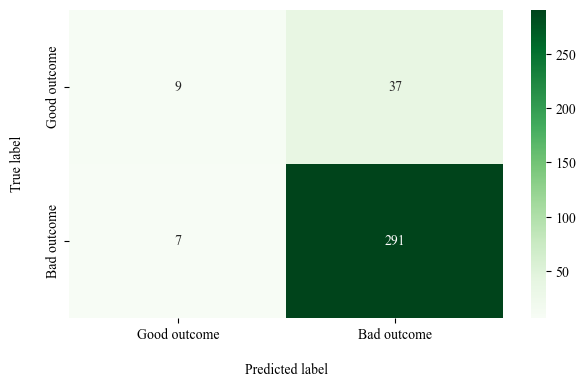

In [18]:
#Calculate and print AUC of model
auc_nonreperfusion_RFnr = roc_auc_score(y_test_nonreperfusion, y_pred_proba_nonreperfusion_RFnr)
print(f"AUC nonreperfusion:\t\t\t {auc_nonreperfusion_RFnr:.2}")

y_pred_nonreperfusion_RFnr = clf_RFnr.predict(X_test_nonreperfusion)
print_confusion_matrix(confusion_matrix(y_test_nonreperfusion, y_pred_nonreperfusion_RFnr), ["Good outcome", "Bad outcome"]);
print(classification_report(y_test_nonreperfusion, y_pred_nonreperfusion_RFnr))

In [20]:
# Test score and CV score
CV_score_RFnr = np.mean(cross_val_score(clf_RFnr, X_train_nonreperfusion, y_train_nonreperfusion, cv=5))
Test_score_RFnr = accuracy_score(y_true = y_test_nonreperfusion, y_pred = clf_RFnr.predict(X_test_nonreperfusion))

In [21]:
# cross validation and test score for RFnr
print(f'CV score: {round(CV_score_RFnr * 100, 2)}')
print(f'Test score: {round(Test_score_RFnr * 100, 2)}')

CV score: 87.12
Test score: 87.21


In [22]:
# lower and upper bounds of AUROC and AUPRC for RFnr
RFnr_eval_results = calculate_bootstrap_roc_pr(y_test_nonreperfusion, y_pred_proba_nonreperfusion_RFnr)
print(f"AUROC: {RFnr_eval_results['auroc'][0]:.2f} (95% CI: [{RFnr_eval_results['auroc'][1]:.2f}, {RFnr_eval_results['auroc'][2]:.2f}])")
print(f"AUPRC: {RFnr_eval_results['auprc'][0]:.2f} (95% CI: [{RFnr_eval_results['auprc'][1]:.2f}, {RFnr_eval_results['auprc'][2]:.2f}])")

AUROC: 0.85 (95% CI: [0.79, 0.90])
AUPRC: 0.97 (95% CI: [0.96, 0.98])


### Visualization

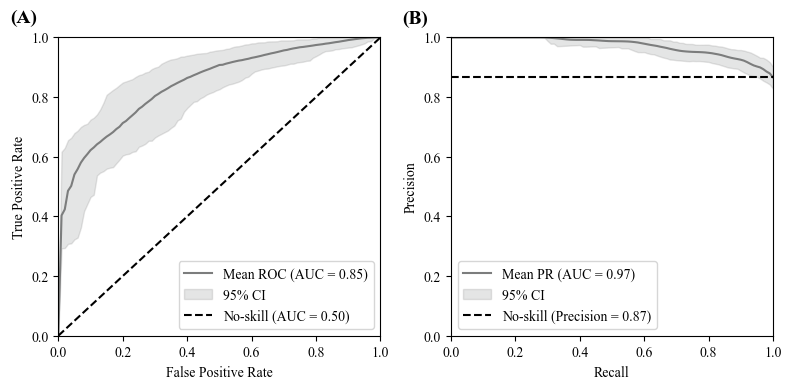

In [23]:
# plotting ROC and PR curves with no-skill for RFnr
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(RFnr_eval_results['base_fpr'], RFnr_eval_results['mean_tpr'], '#7c7d7d',
         label='Mean ROC (AUC = {:.2f})'.format(RFnr_eval_results['auroc'][0]))
plt.fill_between(RFnr_eval_results['base_fpr'], RFnr_eval_results['tpr_ci_lower'],
                 RFnr_eval_results['tpr_ci_upper'], color='#7c7d7d', alpha=0.2, label='95% CI')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], 'k--', label='No-skill (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.text(-0.15, 1.05, '(A)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')

no_skill = len(y_test_nonreperfusion[y_test_nonreperfusion ==1]) / len(y_test_nonreperfusion)

plt.subplot(1, 2, 2)
plt.plot(RFnr_eval_results['base_recall'], RFnr_eval_results['mean_precision'], '#7c7d7d',
         label='Mean PR (AUC = {:.2f})'.format(RFnr_eval_results['auprc'][0]))
plt.fill_between(RFnr_eval_results['base_recall'], RFnr_eval_results['precision_ci_lower'],
                 RFnr_eval_results['precision_ci_upper'], color='#7c7d7d', alpha=0.2, label='95% CI')
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No-skill (Precision = {:.2f})'.format(no_skill))

plt.axis([0, 1, 0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.text(-0.15, 1.05, '(B)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('RFnr curves.png')
plt.show()

#### RF<sub>nr</sub> Feature Importance

In [24]:
# Permutation based feature importance
permutation_importance_result = permutation_importance(clf_RFnr, X_train_nonreperfusion, y_train_nonreperfusion, n_repeats=100, random_state=42)
feature_importance_pi_RFnr = pd.DataFrame({
    'Feature': X_test_nonreperfusion.columns,
    'Importance': permutation_importance_result.importances_mean
})
feature_importance_pi_RFnr = feature_importance_pi_RFnr.sort_values(by='Importance', ascending=False)
feature_importance_pi_RFnr

,Feature,Importance
4,NIHSS at admission,0.019440
0,Age,0.014461
3,pre-mRS,0.012584
9,ASPECTS,0.009148
10,IVT,0.005298
6,Diabetes mellitus,0.004680
7,Dyslipidemia,0.003799
20,proximal M1 occlusion,0.002540
2,Antithrombotic medication,0.002191
13,BA occlusion,0.002154


## Training RF<sub>r</sub>

In [25]:
param_grid = []
for max_depth in np.arange(5, floor(0.5 * len(pre_treat_features))):
    for min_samples_leaf in np.arange(40, 60):
        min_samples_split = 2 * min_samples_leaf
        param_grid.append({
            'max_depth': [max_depth],
            'min_samples_leaf': [min_samples_leaf],
            'min_samples_split': [min_samples_split],
            'n_estimators': [500]
        })
        
clf_RFr_base = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=rnd_num),
                     param_grid=param_grid,
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_num),
                       scoring = 'balanced_accuracy',
                       refit=True,
                       n_jobs = 10
                     )

clf_RFr_base.fit(X_train_reperfusion,y_train_reperfusion)

print('Before Calibration:\n')
print(clf_RFr_base.best_estimator_)

# Training results
print(f'CV score: {round(clf_RFr_base.best_score_, 2)}')
print(f"Test Score is: {clf_RFr_base.score(X_test_reperfusion, y_test_reperfusion):.2f}")

Before Calibration:

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=52, min_samples_split=104,
                       n_estimators=500, random_state=42)
CV score: 0.75
Test Score is: 0.76


In [26]:
# calibration of RFr model using isotonic method
clf_RFr = CalibratedClassifierCV(clf_RFr_base, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_num), method='isotonic')
clf_RFr.fit(X_test_reperfusion,y_test_reperfusion)

y_pred_proba_reperfusion_RFr = clf_RFr.predict_proba(X_test_reperfusion)[::,1]
prob_true, prob_pred = calibration_curve(y_test_reperfusion, y_pred_proba_reperfusion_RFr, n_bins=5, strategy='quantile')

In [27]:
model = sm.OLS(prob_true, sm.add_constant(prob_pred)).fit()
intercept_RFr, slope_RFr = model.params
print(f'\nCalibration Intercept: {intercept_RFr:.3f}')
print(f'Calibration Slope: {slope_RFr:.3f}')


Calibration Intercept: -0.010
Calibration Slope: 1.017


### Evaluating RF<sub>r</sub>

AUC Control:		 0.85
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       765
           1       0.79      0.87      0.83      1303

    accuracy                           0.77      2068
   macro avg       0.76      0.74      0.75      2068
weighted avg       0.77      0.77      0.77      2068



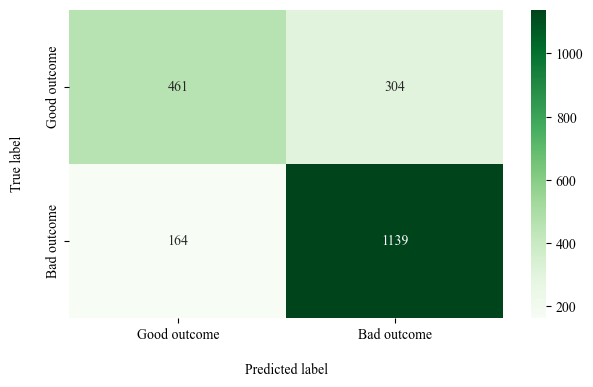

In [28]:
#Calculate and print AUC of model
auc_reperfusion_RFr = roc_auc_score(y_test_reperfusion, y_pred_proba_reperfusion_RFr)
print(f"AUC nonreperfusion:\t\t {auc_reperfusion_RFr:.2}")

y_pred_reperfusion_RFr = clf_RFr.predict(X_test_reperfusion)
print_confusion_matrix(confusion_matrix(y_test_reperfusion, y_pred_reperfusion_RFr), ["Good outcome", "Bad outcome"]);
print(classification_report(y_test_reperfusion, y_pred_reperfusion_RFr))

In [29]:
# test score and CV score
CV_score_RFr = np.mean(cross_val_score(clf_RFr, X_train_reperfusion, y_train_reperfusion, cv=5))
Test_score_RFr = accuracy_score(y_true = y_test_reperfusion, y_pred = clf_RFr.predict(X_test_reperfusion))

In [52]:
# cross validation and test score for RFr
print(f'CV score: {round(CV_score_RFr * 100, 2)}')
print(f'Test score: {round(Test_score_RFr * 100, 2)}')

CV score: 75.75
Test score: 77.37


In [31]:
# lower and upper bounds of AUROC and AUPRC for RFr
RFr_eval_results = calculate_bootstrap_roc_pr(y_test_reperfusion, y_pred_proba_reperfusion_RFr)
print(f"AUROC: {RFr_eval_results['auroc'][0]:.2f} (95% CI: [{RFr_eval_results['auroc'][1]:.2f}, {RFr_eval_results['auroc'][2]:.2f}])")
print(f"AUPRC: {RFr_eval_results['auprc'][0]:.2f} (95% CI: [{RFr_eval_results['auprc'][1]:.2f}, {RFr_eval_results['auprc'][2]:.2f}])")

AUROC: 0.85 (95% CI: [0.83, 0.86])
AUPRC: 0.91 (95% CI: [0.89, 0.92])


### Visualization

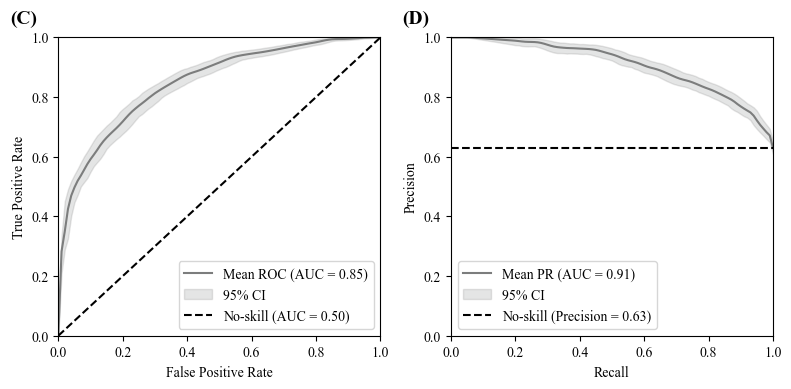

In [33]:
# plotting ROC and PR curves with no-skill for RFr
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(RFr_eval_results['base_fpr'], RFr_eval_results['mean_tpr'], '#7c7d7d', label='Mean ROC (AUC = {:.2f})'.format(RFr_eval_results['auroc'][0]))
plt.fill_between(RFr_eval_results['base_fpr'], RFr_eval_results['tpr_ci_lower'], RFr_eval_results['tpr_ci_upper'], color='#7c7d7d', alpha=0.2, label='95% CI')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], 'k--', label='No-skill (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve with 95% CI')
plt.legend(loc='lower right')
plt.text(-0.15, 1.05, '(C)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')

no_skill = len(y_test_reperfusion[y_test_reperfusion ==1]) / len(y_test_reperfusion)

plt.subplot(1, 2, 2)
plt.plot(RFr_eval_results['base_recall'], RFr_eval_results['mean_precision'], '#7c7d7d', label='Mean PR (AUC = {:.2f})'.format(RFr_eval_results['auprc'][0]))
plt.fill_between(RFr_eval_results['base_recall'], RFr_eval_results['precision_ci_lower'], RFr_eval_results['precision_ci_upper'], color='#7c7d7d', alpha=0.2, label='95% CI')
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No-skill (Precision = {:.2f})'.format(no_skill))
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('PR Curve with 95% CI')
plt.legend(loc='lower left')
plt.text(-0.15, 1.05, '(D)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('RFr curves.png')
plt.show()

#### RF<sub>r</sub> Feature importance

In [34]:
# permutation-based feature importance
permutation_importance_result = permutation_importance(clf_RFr, X_train_reperfusion, y_train_reperfusion, n_repeats=100, random_state=rnd_num)
feature_importance_pi_RFr = pd.DataFrame({
    'Feature': X_test_reperfusion.columns,
    'Importance': np.round(permutation_importance_result.importances_mean, 6)
})
feature_importance_pi_RFr = feature_importance_pi_RFr.sort_values(by='Importance', ascending=False)
feature_importance_pi_RFr

,Feature,Importance
4,NIHSS at admission,0.062125
3,pre-mRS,0.048614
0,Age,0.031741
9,ASPECTS,0.008311
10,IVT,0.005223
6,Diabetes mellitus,0.002244
11,TICI before angio,0.000960
17,CA intra T,0.000841
22,MCA-M2 occlusion,0.000742
5,Hypertension,0.000556


In [54]:
# summary of performance results for both RFnr and RFr models
performance_results = pd.DataFrame(columns=['Model','RFnr','RFr'] , index=range(1,13))
performance_results.loc[:, 'Model'] = ['Train Acc', 'CV Acc', 'Test Acc','AUROC', 'AUROC lower bound', 'AUROC upper bound',
                           'AUPRC', 'AUPRC lower bound', 'AUPRC upper bound','Avg F1 Score', 'Intercept' , 'Slope']
performance_results.loc[:, 'RFnr'] = [
                           round(accuracy_score(y_true = y_train_nonreperfusion, y_pred = clf_RFnr.predict(X_train_nonreperfusion))*100,2),
                           round(CV_score_RFnr*100, 2),
                           round(Test_score_RFnr*100, 2),
                           round(RFnr_eval_results['auroc'][0],2),
                         round(RFnr_eval_results['auroc'][1],2),
                         round(RFnr_eval_results['auroc'][2],2),
                         round(RFnr_eval_results['auprc'][0],2),
                         round(RFnr_eval_results['auprc'][1],2),
                         round(RFnr_eval_results['auprc'][2],2),
                           round(f1_score(y_test_nonreperfusion, y_pred_nonreperfusion_RFnr, average='weighted'),2),
                        round(intercept_RFnr, 3),
                        round(slope_RFnr,3)]

performance_results.loc[:, 'RFr'] = [
                           round(accuracy_score(y_true = y_train_reperfusion, y_pred = clf_RFr.predict(X_train_reperfusion))*100,2),
                           round(CV_score_RFr*100, 2),
                           round(Test_score_RFr*100, 2),
                           round(RFr_eval_results['auroc'][0],2),
                         round(RFr_eval_results['auroc'][1],2),
                         round(RFr_eval_results['auroc'][2],2),
                         round(RFr_eval_results['auprc'][0],2),
                         round(RFr_eval_results['auprc'][1],2),
                         round(RFr_eval_results['auprc'][2],2),
                           round(f1_score(y_test_reperfusion, y_pred_reperfusion_RFr, average='weighted'),2),
                        round(intercept_RFr, 3),
                        round(slope_RFr,3)]

performance_results

,Model,RFc,RFf
1,Train Acc,88.86,75.05
2,CV Acc,87.12,75.75
3,Test Acc,87.21,77.37
4,AUROC,0.85,0.85
5,AUROC lower bound,0.79,0.83
6,AUROC upper bound,0.9,0.86
7,AUPRC,0.97,0.91
8,AUPRC lower bound,0.96,0.89
9,AUPRC upper bound,0.98,0.92
10,Avg F1 Score,0.84,0.77


# RF Prediction Phase

## Predicting for nonreperfusion group

In [36]:
# calculate pred probs of whole nonreperfusion group on models RFr and RFr

y_pred_nonreperfusion_all_RFnr = clf_RFnr.predict(df_nonreperfusion[pre_treat_features])
y_pred_proba_nonreperfusion_all_RFnr = clf_RFnr.predict_proba(df_nonreperfusion[pre_treat_features])[:,1]

y_pred_nonreperfusion_all_RFr = clf_RFr.predict(df_nonreperfusion[pre_treat_features])
y_pred_proba_nonreperfusion_all_RFr = clf_RFr.predict_proba(df_nonreperfusion[pre_treat_features])[:,1]

#### Prediction probs distribution chart - nonreperfusion group

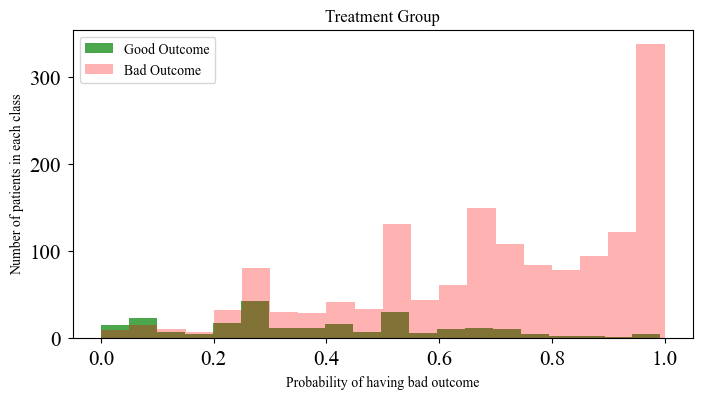

In [37]:
# pred prob distribution for nonreperfusion
plt.figure(figsize=(8,4))
plt.hist(y_pred_proba_nonreperfusion_all_RFr[df_nonreperfusion.D90_mrs_binary==0], bins=20, label='Good Outcome', alpha=0.7, color='g')
plt.hist(y_pred_proba_nonreperfusion_all_RFr[df_nonreperfusion.D90_mrs_binary==1], bins=20, label='Bad Outcome', alpha=0.3, color='r')
plt.xlabel('Probability of having bad outcome', fontsize=10)
plt.ylabel('Number of patients in each class', fontsize=10)
plt.title('reperfusion Group')
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show()

## Predicting for reperfusion group

In [38]:
# calculate pred probs of whole reperfusion on models RFnr and RFr

y_pred_reperfusion_all_RFnr = clf_RFnr.predict(df_reperfusion[pre_treat_features])
y_pred_proba_reperfusion_all_RFnr = clf_RFnr.predict_proba(df_reperfusion[pre_treat_features])[:,1]

y_pred_reperfusion_all_RFr = clf_RFr.predict(df_reperfusion[pre_treat_features])
y_pred_proba_reperfusion_all_RFr = clf_RFr.predict_proba(df_reperfusion[pre_treat_features])[:,1]

#### Prediction probs distribution chart - reperfusion group

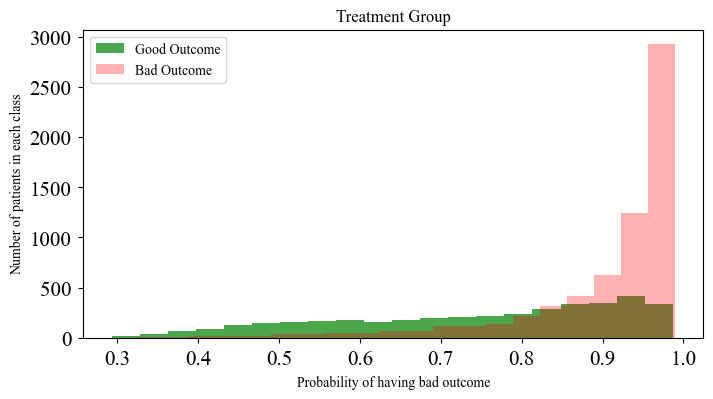

In [39]:
# pred prob distribution for reperfusion
plt.figure(figsize=(8,4))
plt.hist(y_pred_proba_reperfusion_all_RFnr[df_reperfusion.D90_mrs_binary==0], bins=20, label='Good Outcome', alpha=0.7, color='g')
plt.hist(y_pred_proba_reperfusion_all_RFnr[df_reperfusion.D90_mrs_binary==1], bins=20, label='Bad Outcome', alpha=0.3, color='r')
plt.xlabel('Probability of having bad outcome', fontsize=10)
plt.ylabel('Number of patients in each class', fontsize=10)
plt.title('reperfusion Group')
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show()

## Statistical Analysis


In [40]:
# Conducting two-sample ttest for comparing predictions and actual outcomes
result = pg.ttest(y_pred_reperfusion_all_RFnr,
                  df_reperfusion.D90_mrs_binary,
                  correction=True)
 
alpha = 0.05 # Significance Level

print(f"p-value: {result['p-val'][0]}")
if result['p-val'][0] < alpha:
    print("We reject null hypothesis in favor of alternative hypothesis!\nThere is significant difference between the groups")
else:
    print("We fail to reject null hypothesis")

p-value: 0.0
We reject null hypothesis in favor of alternative hypothesis!
There is significant difference between the groups


## Final Results - nonreperfusion group

In [41]:
df_nonreperfusion_base = df.query("`Final TICI` <= 2")[pre_treat_features]
df_nonreperfusion_base['D90_mrs_binary'] = df.query("`Final TICI` <= 2")['D90_mrs_binary']
df_nonreperfusion_base['D90_mrs_binary'] = df.query("`Final TICI` <= 2")['D90_mrs_binary']

In [42]:
df_nonreperfusion_conc = df_nonreperfusion_base.copy(deep=True)
df_nonreperfusion_conc['pred_prob_RFnr'] = y_pred_proba_nonreperfusion_all_RFnr
df_nonreperfusion_conc['pred_prob_RFr'] = y_pred_proba_nonreperfusion_all_RFr
df_nonreperfusion_conc['pred_RF'] = y_pred_nonreperfusion_all_RFnr
df_nonreperfusion_conc['ITE'] = y_pred_proba_nonreperfusion_all_RFnr - y_pred_proba_nonreperfusion_all_RFr

## Final Results - reperfusion group

In [43]:
df_reperfusion_base = df.query("`Final TICI` >= 3")[pre_treat_features]
df_reperfusion_base['D90_mrs_binary'] = df.query("`Final TICI` >= 3")['D90_mrs_binary']
df_reperfusion_base['D90_mrs_binary'] = df.query("`Final TICI` >= 3")['D90_mrs_binary']

In [44]:
df_reperfusion_conc = df_reperfusion_base.copy(deep=True)
df_reperfusion_conc['pred_prob_RFnr'] = y_pred_proba_reperfusion_all_RFnr
df_reperfusion_conc['pred_prob_RFr'] = y_pred_proba_reperfusion_all_RFr
df_reperfusion_conc['pred_RF'] = y_pred_reperfusion_all_RFnr
df_reperfusion_conc['ITE'] = y_pred_proba_reperfusion_all_RFnr - y_pred_proba_reperfusion_all_RFr

In [45]:
print(f"Number of non-treated patients with no benefit: {len(df_nonreperfusion_conc.loc[df_nonreperfusion_conc['ITE'] < 0])}")
print(f"Number of treated patients with no benefit: {len(df_reperfusion_conc.loc[df_reperfusion_conc['ITE'] < 0])}")

Number of non-treated patients with no benefit: 301
Number of treated patients with no benefit: 1364


### Average causal effect for the two groups

In [46]:
# Bootstrap for the average ITE and number of nonreperfusion group patients with negative ITE
mean_lengths, mean_len, n_iter = [], [], 1000
for i in range(n_iter):
    temp_sample = np.random.choice(df_nonreperfusion_conc['ITE'], replace=True, size=len(df_nonreperfusion_conc['ITE']))
    sample_mean = np.mean(temp_sample)
    mean_len.append((temp_sample < 0).sum())
    mean_lengths.append(sample_mean)

# Calculate bootstrapped mean and 95% confidence interval.
print('CI AVE')
boot_mean = np.mean(mean_lengths)
boot_95_ci = np.percentile(mean_lengths, [2.5, 97.5])
print(f"Bootstrapped Mean = {boot_mean*100:.1f}\n95% CI = {np.round(boot_95_ci*100,1)}")

print('\nCI number of patients with negative ITE')
boot_len = np.mean(mean_len)
boot_95_ci = np.percentile(mean_len, [2.5, 97.5])
print(f"Bootstrapped Count = {boot_len:.0f}\n95% CI = {np.round(boot_95_ci,0)}")

CI AVE
Bootstrapped Mean = 19.8
95% CI = [19.1 20.6]

CI number of patients with negative ITE
Bootstrapped Count = 302
95% CI = [270. 334.]


In [47]:
# Bootstrap for the average ITE and number of reperfusion group patients with negative ITE
mean_lengths, mean_len, n_iter = [], [], 1000
for i in range(n_iter):
    temp_sample = np.random.choice(df_reperfusion_conc['ITE'], replace=True, size=len(df_reperfusion_conc['ITE']))
    sample_mean = np.mean(temp_sample)
    mean_len.append((temp_sample < 0).sum())
    mean_lengths.append(sample_mean)

# Calculate bootstrapped mean and 95% confidence interval.
print('CI AVE')
boot_mean = np.mean(mean_lengths)
boot_95_ci = np.percentile(mean_lengths, [2.5, 97.5])
print(f"Bootstrapped Mean = {boot_mean*100:.1f}\n95% CI = {np.round(boot_95_ci*100,1)}")

print('\nCI number of patients with negative ITE')
boot_len = np.mean(mean_len)
boot_95_ci = np.percentile(mean_len, [2.5, 97.5])
print(f"Bootstrapped Count = {boot_len:.0f}\n95% CI = {np.round(boot_95_ci,0)}")

CI AVE
Bootstrapped Mean = 22.0
95% CI = [21.7 22.3]

CI number of patients with negative ITE
Bootstrapped Count = 1365
95% CI = [1293. 1431.]


In [48]:
print(f"Number needed to treat in nonreperfusion group: {calculate_nnt(y_pred_proba_nonreperfusion_all_RFnr , y_pred_proba_nonreperfusion_all_RFr)}")
print(f"Number needed to treat in reperfusion group: {calculate_nnt(y_pred_proba_reperfusion_all_RFnr , y_pred_proba_reperfusion_all_RFr)}")

Number needed to treat in control group: 6
Number needed to treat in treatment group: 5


In [50]:
# description of the estimated ITEs
df_nonreperfusion_conc['ITE'].describe()

count    1718.000000
mean        0.198376
std         0.155364
min        -0.058087
25%         0.054354
50%         0.206192
75%         0.317430
max         0.615413
Name: ITE, dtype: float64

In [51]:
# description of the estimated ITEs
df_reperfusion_conc['ITE'].describe()

count    10339.000000
mean         0.220279
std          0.154668
min         -0.066594
25%          0.080402
50%          0.232605
75%          0.338541
max          0.652956
Name: ITE, dtype: float64